In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import haiku as hk

import jax
import jax.numpy as np

from jax import random
from jax import grad, jit, vmap

import numpy as onp

from IPython import display
from matplotlib import pyplot as plt

In [5]:
plt.rcParams['figure.figsize'] = ((10, 7.5))

In [7]:
key = random.PRNGKey(0)

# 3.2.1. Generating the Dataset

In [8]:
def synthetic_data(w, b, num_examples):
    """Generate y = X w + b + noise."""
    X = random.normal(key, (num_examples, len(w)))
    y = np.dot(X, w) + b
    y += onp.random.normal(0, 0.01, y.shape)
    return X, y

In [9]:
true_w = np.array([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [10]:
print('features:', features[0],'\nlabel:', labels[0])

features: [ 0.27669522 -0.19133605] 
label: 5.4073234


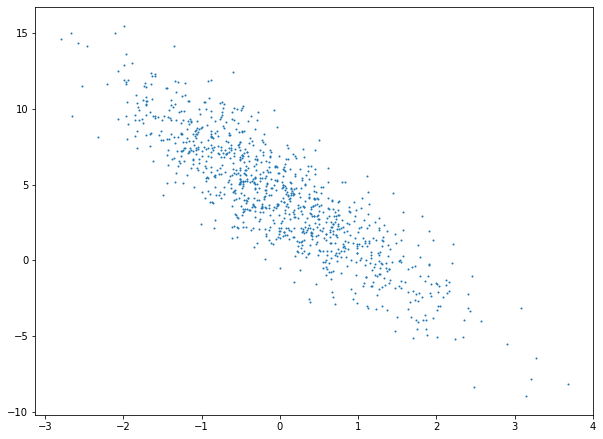

In [12]:
plt.scatter(features[:, 1], labels, 1);

# 3.2.2. Reading the Dataset

In [13]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(key, np.array(indices))
    for i in range(0, num_examples, batch_size):
        batch_indices = np.array(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [14]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

[[ 0.27669522 -0.19133605]
 [-1.4241002   0.23117453]
 [-2.1808553   0.67339027]
 [-0.7535151  -0.56768894]
 [-1.3877213  -1.4285344 ]
 [-0.43773797 -0.5171687 ]
 [-1.1780213  -0.24898684]
 [ 0.5408142   0.6861216 ]
 [ 0.39767596 -1.1651206 ]
 [ 1.508188   -0.95263034]] 
 [ 5.4073234   0.56342953 -2.4392335   4.621217    6.2842193   5.0596504
  2.7015007   2.9499924   8.963368   10.44972   ]


# 3.2.3. Initializing Model Parameters

In [15]:
w = np.array(onp.random.normal(0, 0.01, (2, 1)))
b = np.zeros(1)

In [16]:
w, b

(DeviceArray([[0.00536162],
              [0.00268033]], dtype=float32),
 DeviceArray([0.], dtype=float32))

# 3.2.5. Defining the Loss Function

In [18]:
def squared_loss(y_hat, y):
    return 0.5 * (y_hat - y.reshape(y_hat.shape))**2 

# 3.2.4. Defining the Model

In [19]:
def loss_fn(X, y): 
    net = hk.Sequential([
          hk.Linear(1)
    ])
    
    y_hat = net(X)
    
    return np.mean(squared_loss(y_hat, y))

In [20]:
loss_obj = hk.transform(loss_fn)
loss_obj

Transformed(init=<function without_state.<locals>.init_fn at 0x7f82b95db7b8>, apply=<function without_state.<locals>.apply_fn at 0x7f82b95db840>)

In [23]:
# `init` runs your function, as such we need an example input. Typically you can
# pass "dummy" inputs (e.g. ones of the same shape and dtype) since initialization
# is not usually data dependent.
X, y = next(data_iter(batch_size, features, labels))
X, y

(DeviceArray([[ 0.27669522, -0.19133605],
              [-1.4241002 ,  0.23117453],
              [-2.1808553 ,  0.67339027],
              [-0.7535151 , -0.56768894],
              [-1.3877213 , -1.4285344 ],
              [-0.43773797, -0.5171687 ],
              [-1.1780213 , -0.24898684],
              [ 0.5408142 ,  0.6861216 ],
              [ 0.39767596, -1.1651206 ],
              [ 1.508188  , -0.95263034]], dtype=float32),
 DeviceArray([ 5.4073234 ,  0.56342953, -2.4392335 ,  4.621217  ,
               6.2842193 ,  5.0596504 ,  2.7015007 ,  2.9499924 ,
               8.963368  , 10.44972   ], dtype=float32))

In [25]:
# The result of `init` is a nested data structure of all the parameters in your
# network. You can pass this into `apply`.
params = loss_obj.init(key, X, y)

In [26]:
params

frozendict({
  'linear': frozendict({
              'b': DeviceArray([0.], dtype=float32),
              'w': DeviceArray([[ 0.13024172],
                                [-0.35401073]], dtype=float32),
            }),
})

# 3.2.6. Defining the Optimization Algorithm

In [31]:
def sgd(param, update):
    return param - 0.01 * update

# 3.2.7. Training

In [32]:
lr = 0.03  # Learning rate
num_epochs = 3  # Number of iterations

In [47]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        grads = jax.grad(loss_obj.apply)(params, X, y)
        params = jax.tree_multimap(sgd, params, grads)
    train_l = loss_obj.apply(params, features, labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean()))

epoch 1, loss 0.000051
epoch 2, loss 0.000051
epoch 3, loss 0.000051


In [48]:
print('Error in estimating w', true_w - params['linear']['w'].reshape(true_w.shape))
print('Error in estimating b', true_b - params['linear']['b'])

Error in estimating w [-0.00027418 -0.00036979]
Error in estimating b [-0.00014257]
